### The Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from matplotlib.colors import LinearSegmentedColormap

In [3]:
from matplotlib.colors import ListedColormap
cmap_bold = ListedColormap(['#FF0000','#0000FF'])
cmap_ligt = ListedColormap(['#FFBBBB','#BBBBFF'])

### Utils

In [4]:
def train_test_split(arr, test_size=0.25, random_state=None):

    if random_state is not None:
        np.random.seed(random_state)
    
    n = arr.shape[0]
    if isinstance(test_size, float):
        test_count = int(n * test_size)
    else:
        test_count = test_size
    
    indices = np.random.permutation(n)
    test_indices = indices[:test_count]
    train_indices = indices[test_count:]
    
    train_arr = arr[train_indices]
    test_arr = arr[test_indices]
    
    return train_arr, test_arr

def countplott(cat_columns,df):
    num_cols = len(cat_columns)
    fig, axes = plt.subplots(nrows=1, ncols=num_cols, figsize=(5*num_cols, 5))

    for i, col in enumerate(cat_columns):
        sns.countplot(x=col, data=df, ax=axes[i],color='green')
        axes[i].set_title(f'Count plot of {col}')
        axes[i].tick_params(axis='x', rotation=45)

    # plt.tight_layout()
    plt.show()

def accuracy(y, y_hat):
    return np.mean(y==y_hat)

def correlation_matrix(df):
    corr_mat = df.corr()

    colors = ["#8a1f2a", "#b22937", "#ffffff", "#b22937", "#8a1f2a"]
    cmap = LinearSegmentedColormap.from_list("custom_reds", colors, N=256)

    plt.figure(figsize=(16,8))
    ax = sns.heatmap(
        corr_mat,
        cmap=cmap,
        center=0,
        annot=True,
        fmt=".3f",
        square=True,
        linewidths=0.5,
        annot_kws={"color": "white"},
        cbar_kws={"shrink": 0.75}
    )

    ax.title.set_color('white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')

    # Set tick labels to white
    ax.tick_params(colors='white')

    # Set figure and axes background to darkest red
    plt.gcf().patch.set_facecolor("#4e0f14")
    ax.set_facecolor("#4e0f14")

    plt.savefig("corr.svg", format='svg')
    plt.show()

def confusion_matrix(y,y_hat):
    plt.figure(figsize=(10,7))
    y_actu = pd.Series(y, name='Actual')
    y_pred = pd.Series(y_hat, name='Predicted')
    cm = pd.crosstab(y_actu, y_pred)
    ax = sns.heatmap(cm, annot=True, fmt="d")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def sigmoid(h):
    return 1/(1+np.exp(-h))

def cross_entropy(y,p_hat):
    return -(1/len(y))*np.sum(y*np.log(p_hat)+(1-y)*np.log(1-p_hat))

def try_model(model,name,X_train,y_train,X_test,y_test, eta=1e-3, epochs=1e3):
    model.fit(X_train,y_train,eta,epochs)
    y_hat_test = model.predict(X_test)
    print("-"*50)
    print("Model: ", name)
    print("-"*50)
    print(f"Acc: {accuracy(y_test,y_hat_test):0.4f}")
    print()
    print()
    return model, y_hat_test

### Data Loading

In [5]:
df = pd.read_csv('Cirrhosis.csv', index_col=0)
df

,duration,status,drug,age,sex,ascites,hepatomology,spiders,edema,bilirubin,cholesterol,albumin,copper,phosphatase,SGOT,triglicerides,platelets,prothrombin,stage
index,,,,,,,,,,,,,,,,,,,
1,400,2,1,21464,1,1,1,1,1.0,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4
2,4500,0,1,20617,1,0,1,1,0.0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3
3,1012,2,1,25594,0,0,0,0,0.5,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4
4,1925,2,1,19994,1,0,1,1,0.5,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4
5,1504,1,2,13918,1,0,1,1,0.0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,1153,0,1,22347,1,0,1,0,0.0,0.4,246.0,3.58,24.0,797.0,91.00,113.0,288.0,10.4,2
309,994,0,2,21294,1,0,0,0,0.0,0.4,260.0,2.75,41.0,1166.0,70.00,82.0,231.0,10.8,2
310,939,0,1,22767,1,0,0,0,0.0,1.7,434.0,3.35,39.0,1713.0,171.00,100.0,234.0,10.2,2


### EDA

In [6]:
cols_to_drop_to_drop_cols = ['duration','status','drug','stage','age']
df.drop(cols_to_drop_to_drop_cols,axis=1,inplace=True)
df.head()

,sex,ascites,hepatomology,spiders,edema,bilirubin,cholesterol,albumin,copper,phosphatase,SGOT,triglicerides,platelets,prothrombin
index,,,,,,,,,,,,,,
1,1,1,1,1,1.0,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2
2,1,0,1,1,0.0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6
3,0,0,0,0,0.5,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0
4,1,0,1,1,0.5,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3
5,1,0,1,1,0.0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 312 entries, 1 to 312
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sex            312 non-null    int64  
 1   ascites        312 non-null    int64  
 2   hepatomology   312 non-null    int64  
 3   spiders        312 non-null    int64  
 4   edema          312 non-null    float64
 5   bilirubin      312 non-null    float64
 6   cholesterol    284 non-null    float64
 7   albumin        312 non-null    float64
 8   copper         310 non-null    float64
 9   phosphatase    312 non-null    float64
 10  SGOT           312 non-null    float64
 11  triglicerides  282 non-null    float64
 12  platelets      308 non-null    float64
 13  prothrombin    312 non-null    float64
dtypes: float64(10), int64(4)
memory usage: 36.6 KB


In [8]:
df.isnull().sum()

sex               0
ascites           0
hepatomology      0
spiders           0
edema             0
bilirubin         0
cholesterol      28
albumin           0
copper            2
phosphatase       0
SGOT              0
triglicerides    30
platelets         4
prothrombin       0
dtype: int64

In [9]:
df.describe()

,sex,ascites,hepatomology,spiders,edema,bilirubin,cholesterol,albumin,copper,phosphatase,SGOT,triglicerides,platelets,prothrombin
count,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,284.000000,312.000000,310.000000,312.000000,312.000000,282.000000,308.000000,312.000000
mean,0.884615,0.076923,0.512821,0.288462,0.110577,3.256090,369.510563,3.520000,97.648387,1982.655769,122.556346,124.702128,261.935065,10.725641
std,0.319999,0.266897,0.500639,0.453775,0.274507,4.530315,231.944545,0.419892,85.613920,2140.388824,56.699525,65.148639,95.608742,1.004323
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.800000,249.500000,3.310000,41.250000,871.500000,80.600000,84.250000,199.750000,10.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,1.350000,309.500000,3.550000,73.000000,1259.000000,114.700000,108.000000,257.000000,10.600000
75%,1.000000,0.000000,1.000000,1.000000,0.000000,3.425000,400.000000,3.800000,123.000000,1980.000000,151.900000,151.000000,322.500000,11.100000
max,1.000000,1.000000,1.000000,1.000000,1.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,563.000000,17.100000


In [10]:
num_cols = ['bilirubin','cholesterol','albumin','copper','phosphatase','SGOT','triglicerides','platelets','prothrombin']
cat_cols = ['sex','hepatomology']

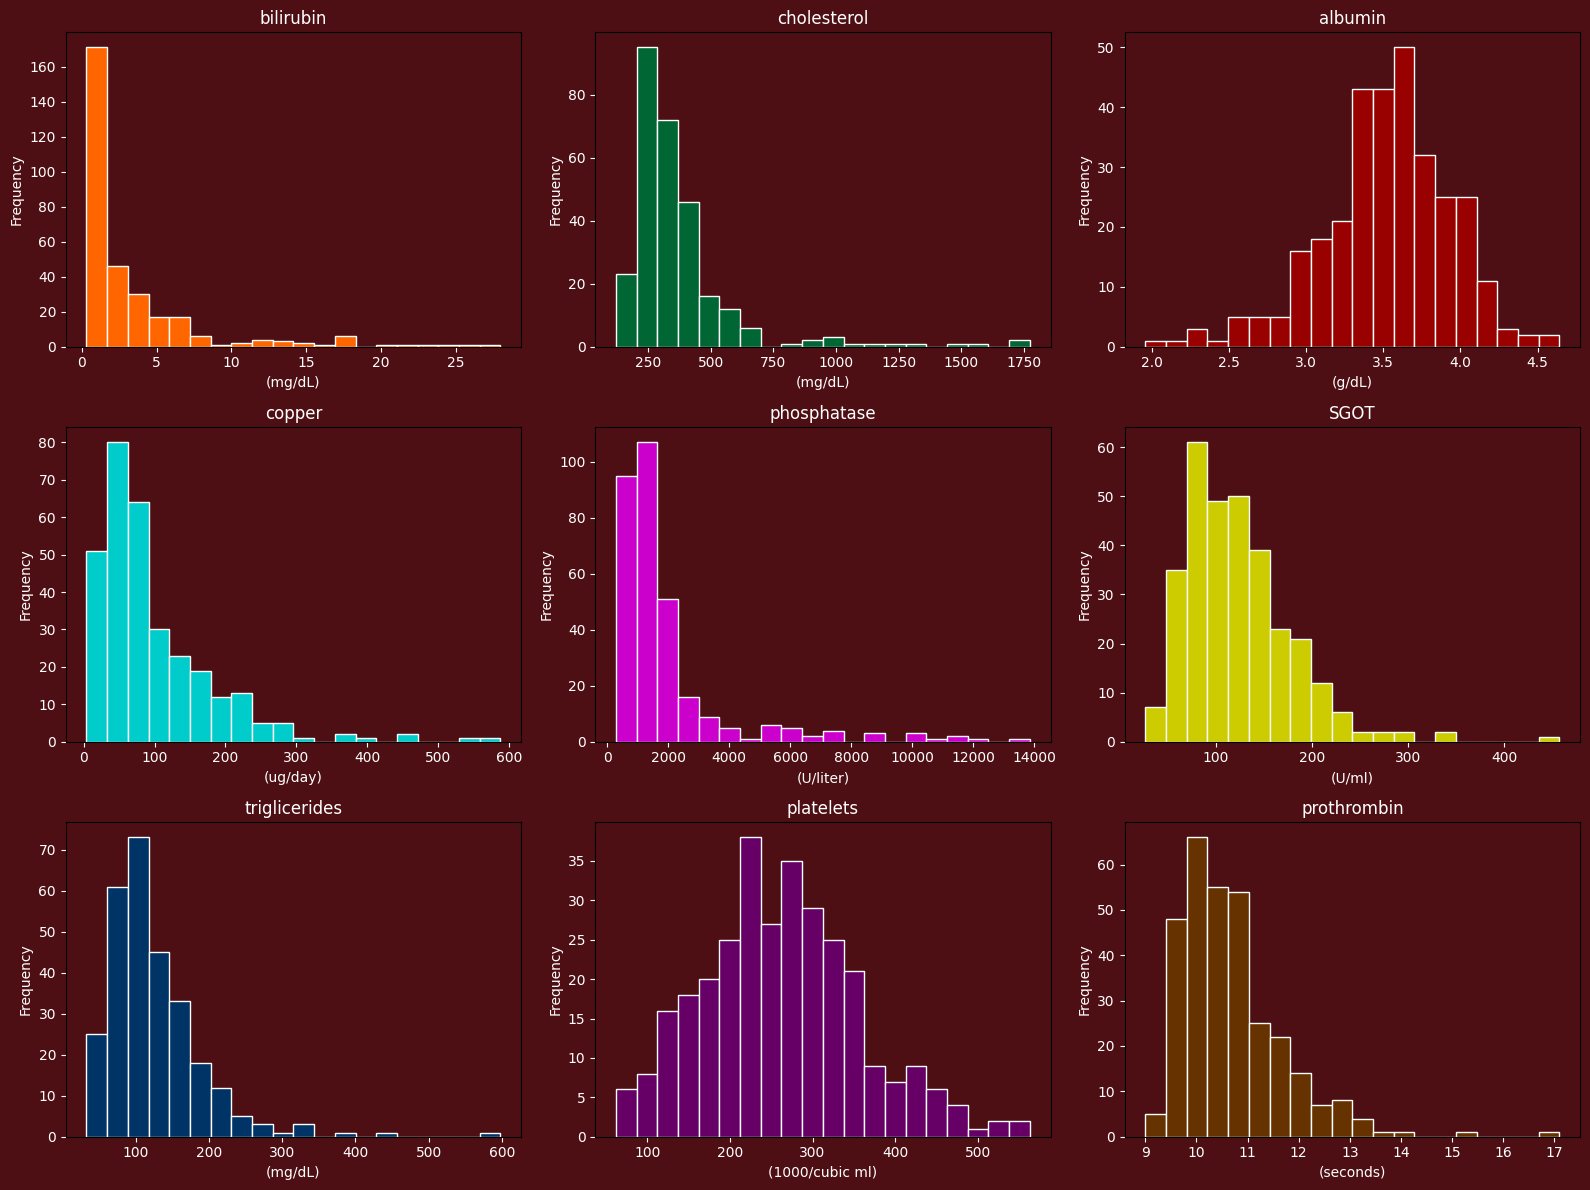

In [11]:
units = {
    'bilirubin': 'mg/dL',
    'cholesterol': 'mg/dL',
    'albumin': 'g/dL',
    'copper': 'ug/day',
    'phosphatase': 'U/liter',
    'SGOT': 'U/ml',
    'triglicerides': 'mg/dL',
    'platelets': '1000/cubic ml',
    'prothrombin': 'seconds'
}


colors = ['#FF6600', '#006633', '#990000', '#00CCCC', '#CC00CC', '#CCCC00', '#003366', '#660066', '#663300']
# colors = ['b', 'g', 'r', 'c', 'm', 'y', 'orange', 'purple', 'brown']
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))
axes = axes.flatten()

# Set figure background to darkest red for consistency
fig.patch.set_facecolor("#4e0f14")

for ax in axes:
    ax.set_facecolor("#4e0f14")  # subplot background dark red
    # Set white text for titles, labels, and ticks
    ax.title.set_color('white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(colors='white')

for i, col in enumerate(num_cols):
    ax = axes[i]
    df[col].hist(bins=20, color=colors[i], edgecolor='white', ax=ax, grid=False)
    ax.set_title(col)
    ax.set_xlabel(f'({units[col]})')
    ax.set_ylabel('Frequency')


plt.tight_layout()
plt.savefig('histogram.svg',format='svg')
plt.show()



In [12]:
# countplott(cat_cols,df)

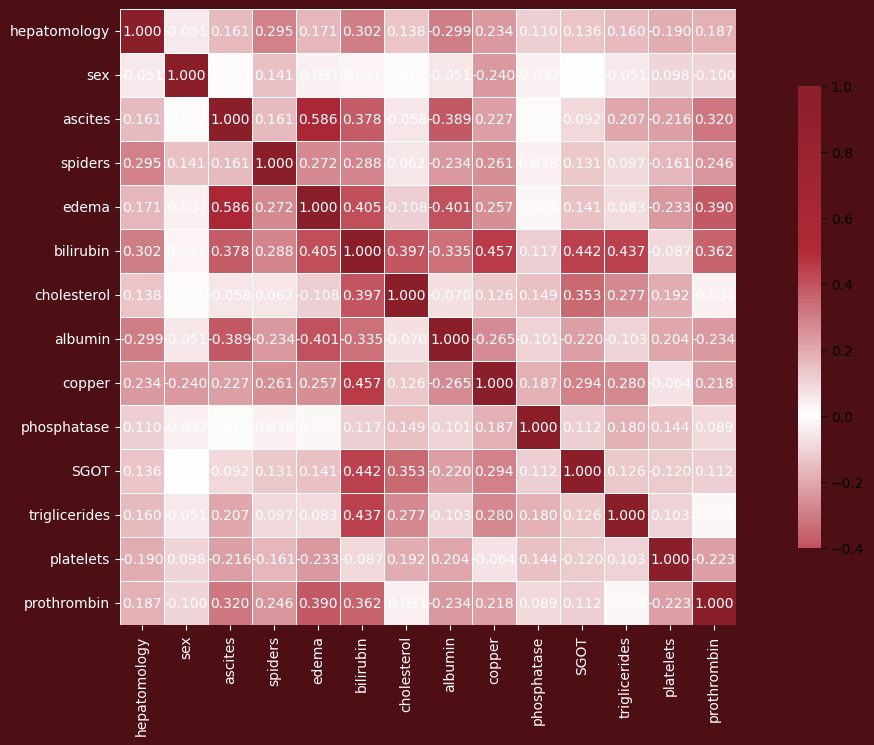

In [13]:
col_data = df.pop('hepatomology')
df.insert(0,'hepatomology',col_data)
correlation_matrix(df)

In [14]:
df.fillna(df.mean(),inplace=True)

### Pre Processing

In [ ]:
X = df.loc[:, df.columns != 'hepatomology'].to_numpy()
y = df['hepatomology'].to_numpy()

In [ ]:
X_train, X_test = train_test_split(X,0.11,42)
y_train, y_test = train_test_split(y,0.11,42)
X_test.shape

In [ ]:
rscaler = RobustScaler()
X_train_rs = rscaler.fit_transform(X_train)
X_test_rs = rscaler.transform(X_test)


### Models

In [ ]:
class LogisticRegression():
    def __init__(self,thresh=0.5):
        self.thresh = thresh
        self.W = None
        self.b = None
    
    def fit(self,X,y,eta=1e-3,epochs=1e3,show_curve=True):
        epochs = int(epochs)
        N,D = X.shape

        #Random Initializatoin of Weights and Biases
        np.random.seed(42)
        self.W = np.random.randn(D)
        self.b = np.random.randn(1)
        # self.W = np.array([0.36049517,  0.55346248,  0.26647535, -0.40228128,  0.30630106,  0.10130677, -0.20876461, -0.10300545, -0.47500598,  0.08588924])
        # log_reg.b = np.array([-0.30574449])
        # Build Contianer for Loses
        J = np.zeros(epochs)

        #SGD Progression
        for epoch in range(epochs):
            p_hat = self.__forward__(X)
            J[epoch] = cross_entropy(y,p_hat)
            # Weights and Biases Update Rules
            self.W -= eta*(1/N)*X.T@(p_hat - y)
            self.b -= eta* (1/N)*np.sum(p_hat - y)
        
        if show_curve:
            plt.figure()
            plt.plot(J)
            plt.xlabel("epochs")
            plt.ylabel(r"$\mathcal{J}$")
            plt.title("Training Curse")

    def __forward__(self,X):
        return sigmoid(X@self.W+self.b)
    
    def predict(self,X):
        return (self.__forward__(X) >=self.thresh).astype(np.int32)

In [ ]:
log_reg = LogisticRegression(thresh=0.37)
log_reg,y_hat_test_log = try_model(model=log_reg, name='Logistic Regression',X_train=X_train_rs,y_train= y_train,X_test= X_test_rs,y_test= y_test, eta=1.5e-3,epochs=3e4)
confusion_matrix(y_test,y_hat_test_log)